Sentiment Analysis

In [11]:
import tensorflow as tf
from datasets import load_dataset
from transformers import BertTokenizer
from einops import rearrange, repeat
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset("sst", "default")

In [3]:
# longest sentence 267 -> max seqzence lengtha and input ? -> padding
train_data = dataset["train"]["sentence"]
# labels are floats between 0 and 1, need to be rounded to zero or 1 for sentiment classification
train_labels = dataset["train"]["label"]
print(len(train_data))

val_data = dataset["validation"]["sentence"]
# labels are floats between 0 and 1, need to be rounded to zero or 1 for sentiment classification
val_labels = dataset["validation"]["label"]
print(len(val_data))


8544
1101


In [4]:

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
vocab_size = tokenizer.vocab_size

In [5]:
def data_preprocessing(data, targets, tokenizer, max_length):
  tokenized_data = []
  for input in data:
      t = tokenizer.encode_plus(text=input, max_length=max_length, padding="max_length")
      tokenized_data.append(t["input_ids"])
  binary_targets = tf.math.round(targets)
  dataset = tf.data.Dataset.from_tensor_slices((tokenized_data, binary_targets))
  dataset = dataset.shuffle(1000).batch(32).prefetch(4)
  return dataset

train_dataset = data_preprocessing(train_data, train_labels, tokenizer, 267)
validation_dataset = data_preprocessing(val_data, val_labels, tokenizer, 267)

In [6]:
class MambaResBlock(tf.keras.Model):

  def __init__(self, input_dim):
    super().__init__()

    self.input_dim = input_dim
    self.projection_dim = 2*input_dim

    # normalisation
    self.layernorm = tf.keras.layers.LayerNormalization()
    # Dense
    self.dense1 = tf.keras.layers.Dense(units=self.projection_dim)
    # Dense
    self.dense2 = tf.keras.layers.Dense(units=self.projection_dim)
    # Convolution
    self.conv1d = tf.keras.layers.Conv1D(filters=self.projection_dim , kernel_size=4, strides=1 , padding="causal", groups = self.projection_dim, data_format = "channels_last") # data_format?, groups?
    # SSM block
    self.ssm = SelectiveSSM(32, self.projection_dim)
    # Dense
    self.dense3 = tf.keras.layers.Dense(units=input_dim)
    # dropout
    self.dropout = tf.keras.layers.Dropout(rate=0.2)

  # forward step
  def call(self, input):

    x = self.layernorm(input)

    x1 = self.dense1(x)
    x1 = self.conv1d(x1)
    x1 =  tf.nn.silu(x1)
    x1 = self.ssm(x1)

    x2 = self.dense2(x)
    x2 =  tf.nn.silu(x2)

    x = x1 * x2
    x = self.dense3(x)

    # skip connection
    x = x + input

    x = self.dropout(x)

    return x

class SelectiveSSM(tf.keras.Model):
  def __init__(self, states, projection_dim):
    super().__init__()

    self.states = states
    self.projection_dim = projection_dim

    # hippo initialisation für A ? dafür müsste A aber quadratisch sein
    # -> quadratische matrix oder nicht ?
    #self.A =  # states x internal dim
    #self.D =  # np ones internal dim
    A = repeat(tf.range(1, states+1, dtype=tf.float32),'n -> d n', d=self.projection_dim)

    # A parameter: matrix changing hidden state
    self.A_log = tf.Variable(tf.math.log(A),trainable=True, dtype=tf.float32)

    # D parameter: simple skip connection, initialisde as ones
    self.D = tf.Variable(tf.ones(projection_dim),trainable=True, dtype=tf.float32) # change from np to tf

    # B, C, delta parameter: dependend on input, therefore dense layer to learn these
    self.denseB = tf.keras.layers.Dense(units=self.states)
    self.denseC = tf.keras.layers.Dense(units=self.states)
    self.densedelta = tf.keras.layers.Dense(units=self.projection_dim)

  def selective_scan(self,input, delta, A, B, C, D):
    """
    Calculate output of the selective state space model using parallel scan
    implemented using the cumulative sum

    args:
      input: data input that we calculate the ssm on
      delta: mediates how much focus is put on new input
      A: state matrix controlling the hidden state
      B: modulate the recurrent dynamics based on content (input)
      C: modulate the recurrent dynamics based on context (hidden states)
      D: scales the skip connection

    returns:
      output: result of the ssm with current parameters

    """
    # first step of discretization of A
    deltaA = tf.einsum('bld,dn->bldn', delta, A) # quasi delta mal A
    deltaBinput = tf.einsum('bld,bld,bln->bldn', delta, input, B) # input mal B mal delta

    deltaA_cumsum = tf.pad(
        deltaA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, 1:, :, :]

    deltaA_cumsum = tf.reverse(deltaA_cumsum, axis=[1])  # Flip along axis 1

    # Cumulative sum along all the input tokens, parallel prefix sum,
    # calculates dA for all the input tokens in parallel
    deltaA_cumsum = tf.math.cumsum(deltaA_cumsum, axis=1)

    # second step of discretization of A
    deltaA_cumsum = tf.exp(deltaA_cumsum)
    deltaA_cumsum = tf.reverse(deltaA_cumsum, axis=[1])  # Flip back along axis 1

    # calculate intermediate output as in graphs shown for ssm's
    x = deltaBinput * deltaA_cumsum
    # 1e-12 to avoid division by 0
    x = tf.math.cumsum(x, axis=1)/(deltaA_cumsum + 1e-12)

    # intermediate output multiplied with parameter C
    output = tf.einsum('bldn,bln->bld', x, C)

    return output + input * D

  def call(self, input):

    A = -tf.exp(tf.cast(self.A_log, tf.float32))

    C = self.denseC(input)
    B = self.denseB(input)
    # softplus to not get nan values
    delta = tf.nn.softplus(self.densedelta(input))

    return self.selective_scan(input, delta, A, B, C, self.D)

class MambaModel(tf.keras.Model):
  def __init__(self, num_layers, vocab_size, input_dim):
    super().__init__()

    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = input_dim) #, input_length = 128) (bs, 128, 128)
    self.layer_list = []
    for i in range(num_layers):
        self.layer_list.append(MambaResBlock(input_dim))
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(units=1024, activation=tf.nn.gelu)
    self.out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)

  def call(self, input):

    x = self.embedding(input)

    for i in range(self.num_layers):
      x = self.layer_list[i](x)

    x = self.flatten(x)
    x = self.dense(x)
    x = self.out(x)

    return x

In [7]:
model = MambaModel(1, vocab_size, input_dim=267)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

# compile the model (here, adding a loss function and an optimizer)
model.compile(optimizer = optimizer, loss=loss, metrics=["accuracy"])


In [8]:
history = model.fit(train_dataset,validation_data=validation_dataset, epochs=10)

Epoch 1/10


/home/pbrstudent/anaconda3/envs/hsi/lib/python3.10/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'mamba_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1712828650.943443   21578 service.cc:145] XLA service 0x7399f802dd20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712828650.943893   21578 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1712828651.029264   21578 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


267/267 ━━━━━━━━━━━━━━━━━━━━ 2268s 8s/step - accuracy: 0.7927 - loss: 1.2681 - val_accuracy: 0.5068 - val_loss: 0.9433
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2270s 9s/step - accuracy: 0.7351 - loss: 0.5428 - val_accuracy: 0.5068 - val_loss: 0.6955
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2272s 9s/step - accuracy: 0.2527 - loss: 0.7297 - val_accuracy: 0.5068 - val_loss: 0.6940
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2279s 9s/step - accuracy: 0.2355 - loss: 0.7220 - val_accuracy: 0.5068 - val_loss: 0.6942
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2284s 9s/step - accuracy: 0.2296 - loss: 0.7176 - val_accuracy: 0.5068 - val_loss: 0.6938
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2286s 9s/step - accuracy: 0.2377 - loss: 0.7142 - val_accuracy: 0.5068 - val_loss: 0.6934
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2283s 9s/step - accuracy: 0.2494 - loss: 0.7114 - val_accuracy: 0.5068 - val_loss: 0.6936
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2282s 9s/step - accuracy: 0.2542 - loss: 0.7098 - val_accurac

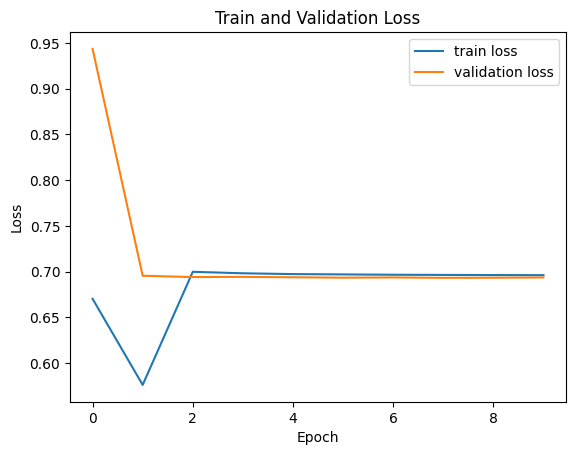

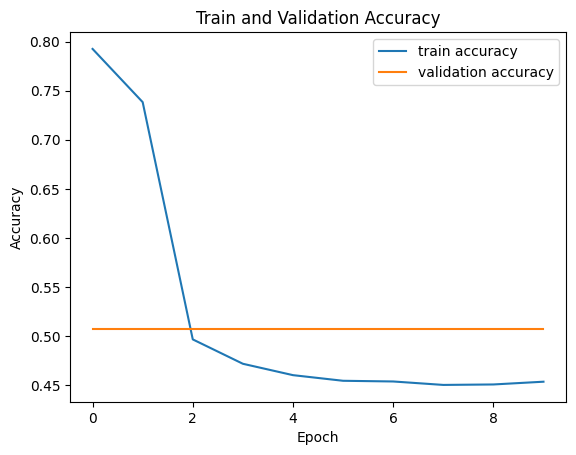

In [12]:
def visualise_results(history):

  plt.plot(history.history["loss"], label="train loss")
  plt.plot(history.history["val_loss"], label="validation loss")
  plt.title("Train and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.plot(history.history["accuracy"], label="train accuracy")
  plt.plot(history.history["val_accuracy"], label="validation accuracy")
  plt.title("Train and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

visualise_results(history)